In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('src/')
from utils.methods import *

In [2]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Prefix path
PREFIX_PATH = 'data'

In [4]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')

In [5]:
df['Genres'] = df['Genres'].apply(str_to_list)
df['merge_year'] = df['merge_year'].astype('Int64')

In [6]:
emotion = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))
emotions_df = pd.concat([df, emotion], axis=1)

# What are the predominant emotional tones used in films and how do they vary across different movie genres?

In [7]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
emotions_without_neutral = ['disgust', 'fear', 'anger', 'sadness', 'surprise', 'joy']

In [8]:
emotion_by_time = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
})
emotion_by_time.columns = emotions

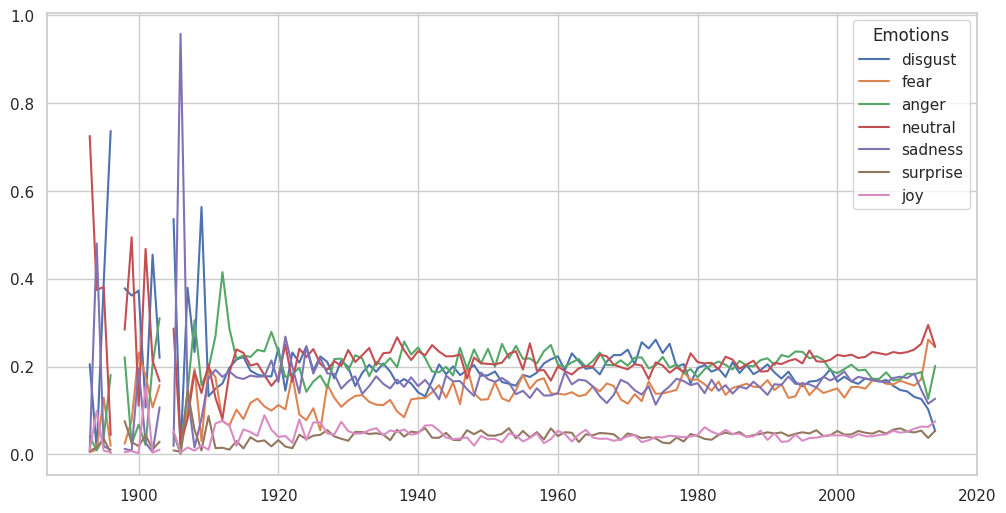

In [9]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

<Axes: xlabel='merge_year', ylabel='Count'>

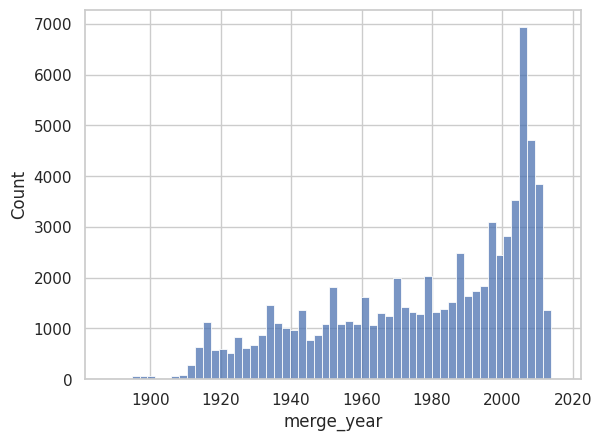

In [10]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [11]:
movie_counts = emotions_df.groupby(['merge_year']).agg(
    counts=('merge_year', 'size')
)
movie_counts[movie_counts.index >= 2010]

,counts
merge_year,
2010,2024
2011,1824
2012,1195
2013,164
2014,17
2015,4
2016,3


In [12]:
emotion_by_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index <= 2012)]

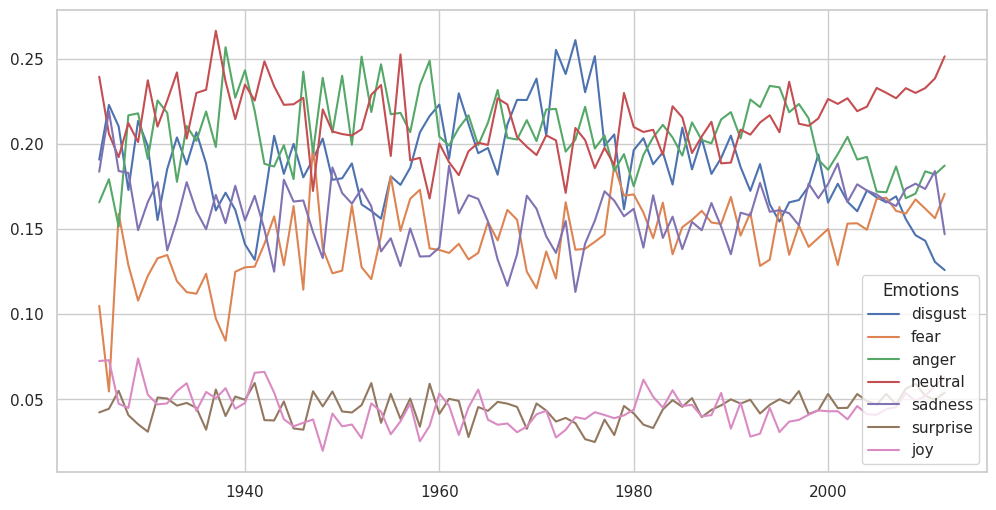

In [13]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

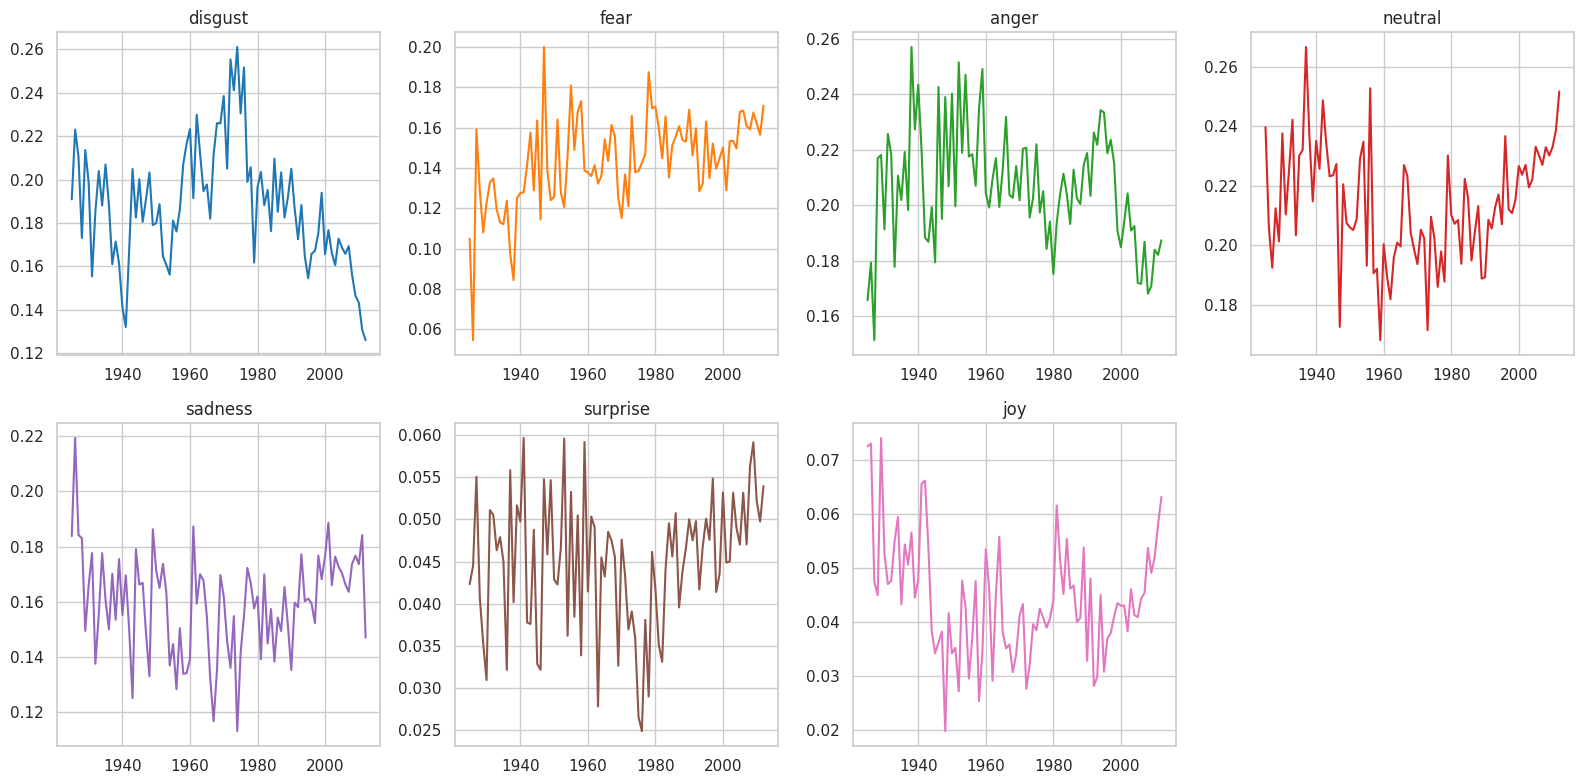

In [14]:
num_emotions = len(emotion_by_time.columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
colors = sns.color_palette("tab10", len(emotion_by_time.columns))

for ax, column, color in zip(axes, emotion_by_time.columns, colors):
    ax.plot(emotion_by_time.index, emotion_by_time[column], color=color)
    ax.set_title(column)

for ax in axes[num_emotions: ]:
    ax.axis('off')

plt.tight_layout()
plt.show()

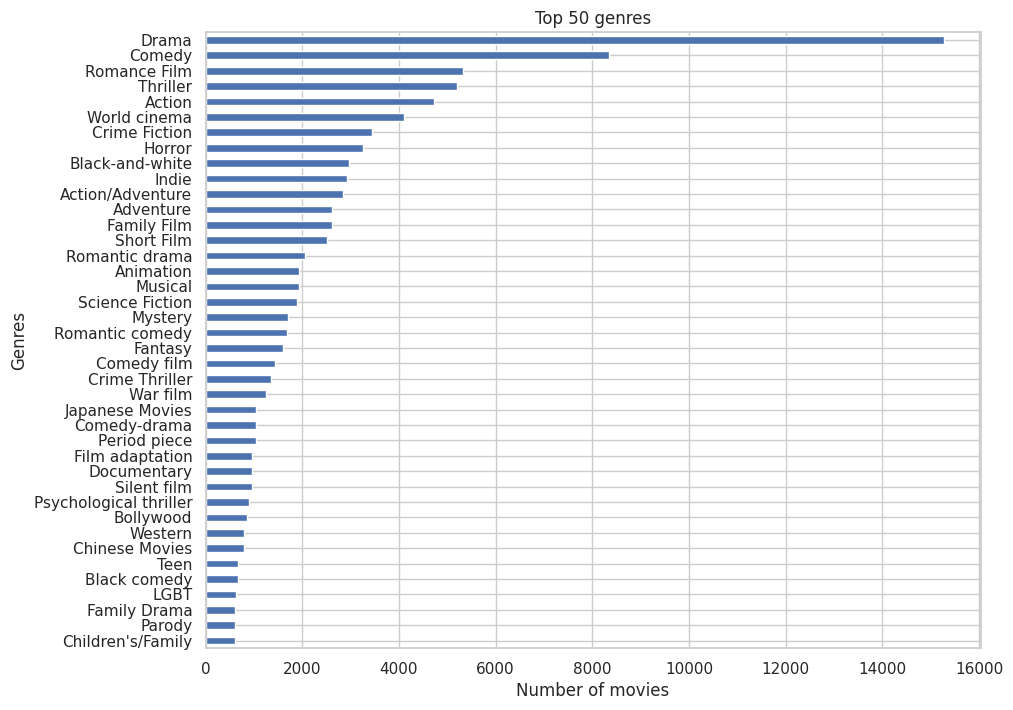

In [15]:
columns_needed = ['Plot', 'Genres', 'merge_year', 'distilbert_emotions']

# we take only the films were the plot is not missing
df_with_plot = df.dropna(subset=['Plot'])[columns_needed]

genre_count = df_with_plot['Genres'].explode().value_counts()

# plot the genre distribution first 50 genres on an orizontal bar plot
plt.figure(figsize=(10, 8))
genre_count[: 40].sort_values().plot(kind='barh')
plt.title('Top 50 genres')
plt.xlabel('Number of movies')
plt.ylabel('Genres')
plt.show()

To choose the relevant genres, we see that there is quite a natural cluster for genres that belong to more than 2000 Movies. To make analysis that have significant results, we choose only those genres that have more than 2000 movies.

In [16]:
relevant_genres = genre_count[genre_count > 2000].index
temp = df_with_plot.explode('Genres')
df_plot_genres = temp[temp['Genres'].isin(relevant_genres)].reset_index(drop=True)

In [17]:
temp = pd.DataFrame(list(df_plot_genres['distilbert_emotions'].apply(conv_to_dict))).reset_index(drop=True)

emotions_df = pd.concat([df_plot_genres, temp], axis=1)

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

temp = emotions_df.groupby('Genres').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()
temp['count'] = emotions_df['Genres'].value_counts().sort_index().values

temp.columns = ['Genres'] + emotions + ['count']
final_df = temp.set_index('Genres')
final_df

,disgust,fear,anger,neutral,sadness,surprise,joy,count
Genres,,,,,,,,
Action,0.164581,0.157858,0.294362,0.207060,0.109015,0.039658,0.027467,4719
Action/Adventure,0.168214,0.164287,0.300741,0.202336,0.107800,0.036135,0.020486,2841
Adventure,0.146760,0.169830,0.226376,0.252786,0.124248,0.048896,0.031105,2608
Black-and-white,0.188865,0.140518,0.211064,0.209114,0.169323,0.041535,0.039581,2958
Comedy,0.159404,0.117332,0.193337,0.261184,0.155883,0.056790,0.056070,8348
Crime Fiction,0.197055,0.170661,0.277801,0.172240,0.124140,0.035676,0.022427,3436
Drama,0.179407,0.137836,0.197994,0.191499,0.206486,0.040810,0.045969,15267
Family Film,0.128007,0.134138,0.191569,0.278214,0.147508,0.063800,0.056763,2608
Horror,0.266120,0.301075,0.162985,0.140338,0.074354,0.044445,0.010683,3266


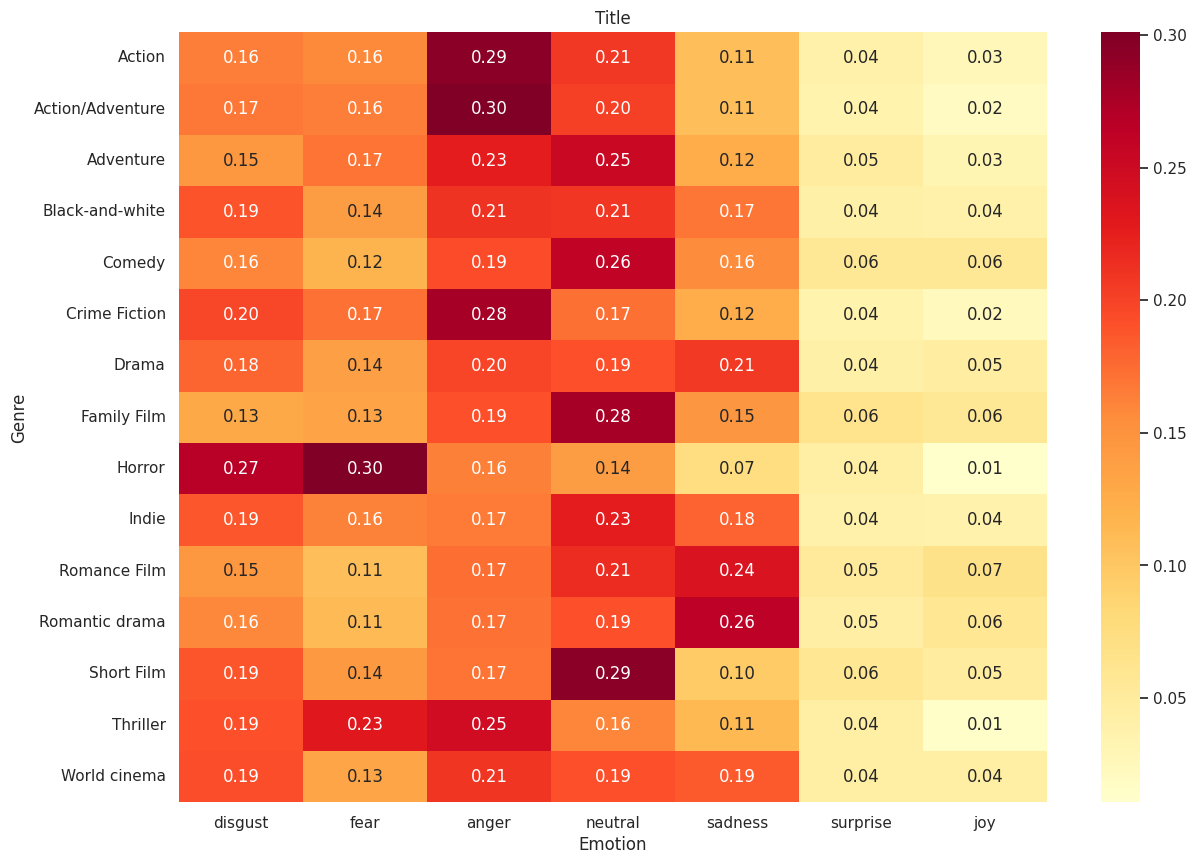

In [18]:
plt.figure(figsize=(14, 10))
sns.heatmap(final_df.drop('count', axis=1), annot=True, fmt='.2f', cbar=True, cmap='YlOrRd')
plt.title('Title')
plt.ylabel('Genre')
plt.xlabel('Emotion')
plt.show()

In [19]:
from statsmodels.multivariate.manova import MANOVA

In [20]:
emotions_df['Genres'] = emotions_df['Genres'].astype('category')

In [21]:
manova = MANOVA.from_formula(f'{ " + ".join(emotions_without_neutral) } ~ Genres', data=emotions_df)
result = manova.mv_test()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.4863 6.0000 68168.0000 12002.9242 0.0000
         Pillai's trace 0.5137 6.0000 68168.0000 12002.9242 0.0000
 Hotelling-Lawley trace 1.0565 6.0000 68168.0000 12002.9242 0.0000
    Roy's greatest root 1.0565 6.0000 68168.0000 12002.9242 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
         Genres         Value   Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.8607 84.0000 379954.0376 123.4368 0.0000
         Pillai's trace 0.1458 84.0000 409038.0000 121.2627 0.0000
 Hotelling-Lawley trace 0.1545 84.0000 279139.1349 125.4173 0.0000
    Roy's greatest root 0.0851 14.0000  68173.0000 414.3267 0.0000
==================================================================

"""

We show the score in tone for each genre in comparison with the average score weighted by the number of movies in each genre.

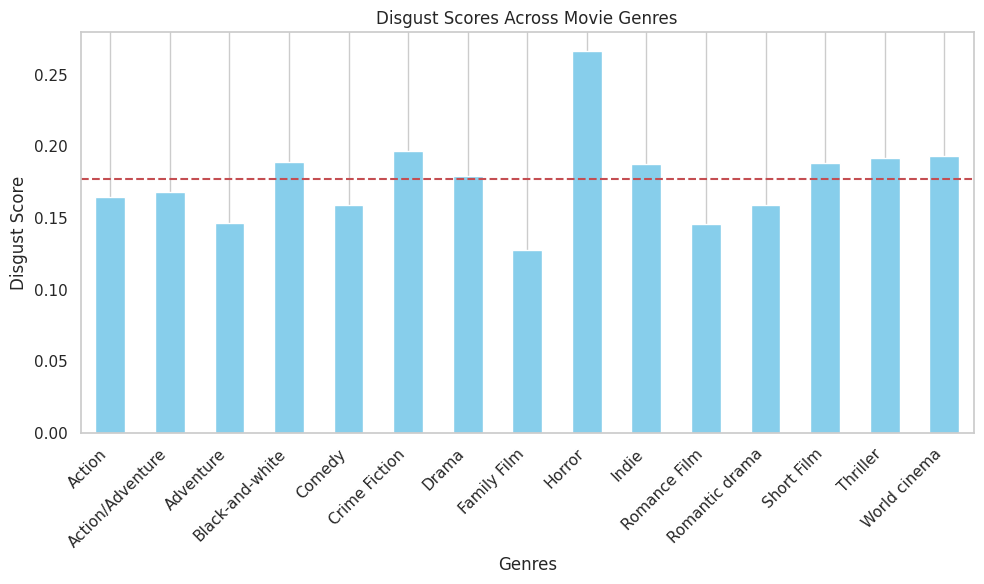

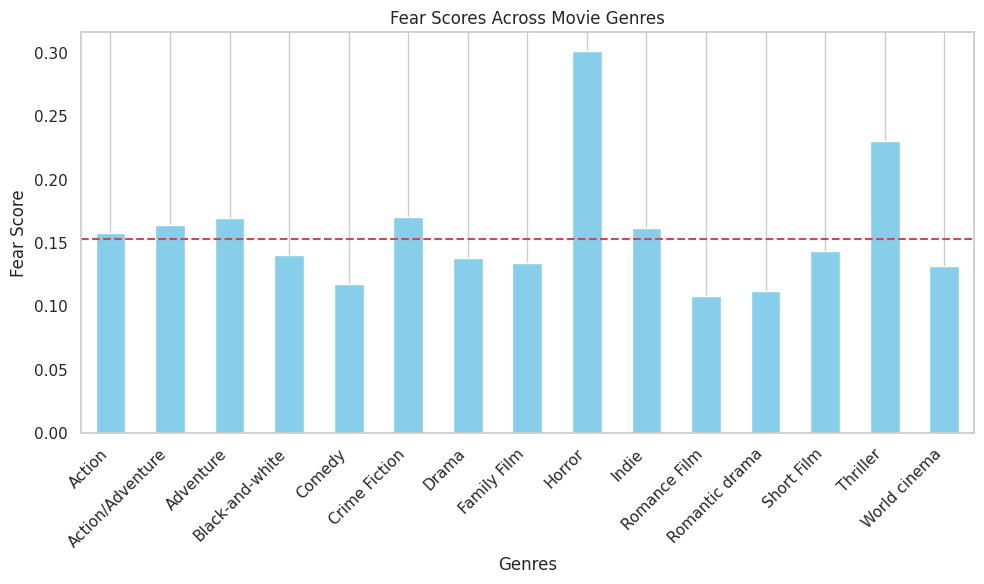

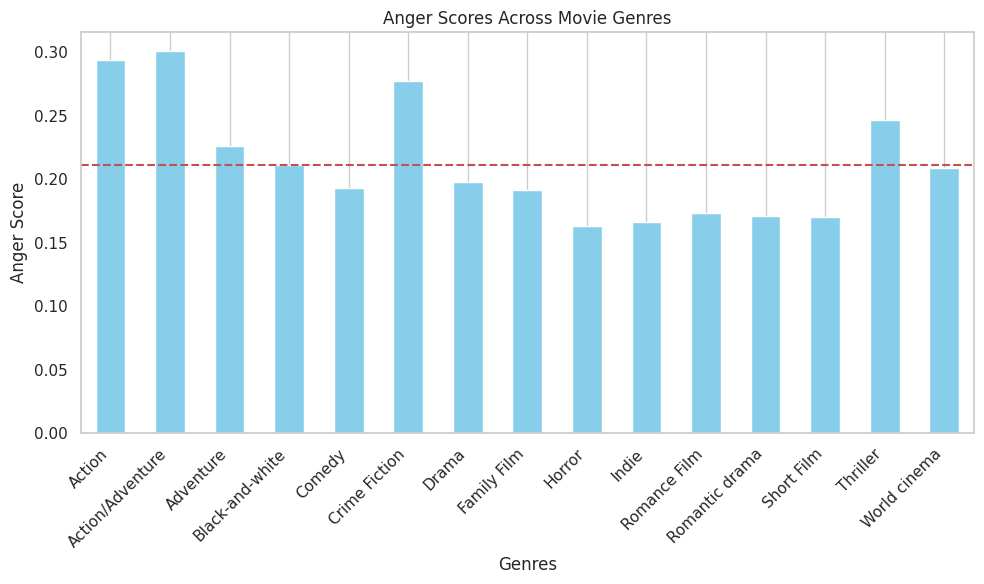

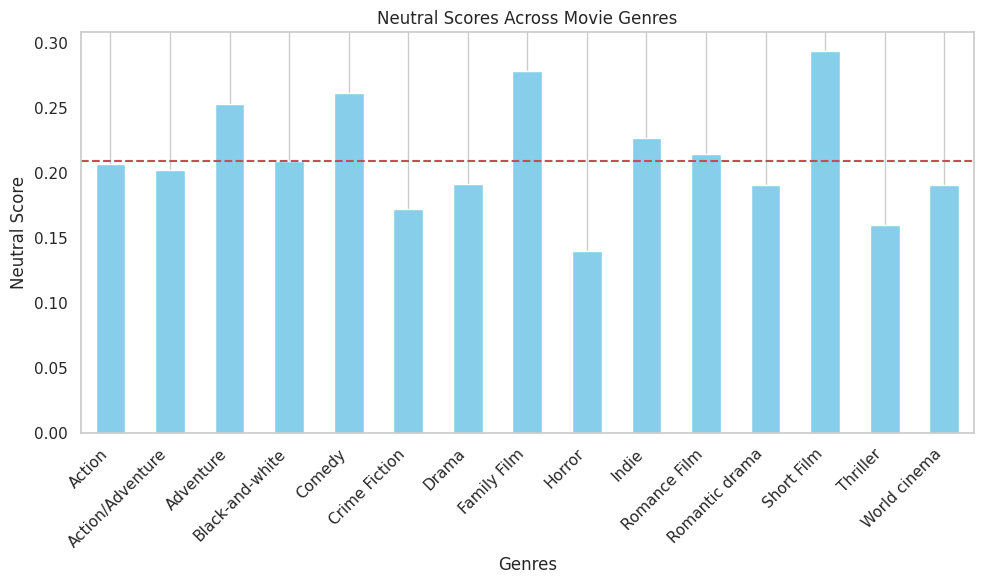

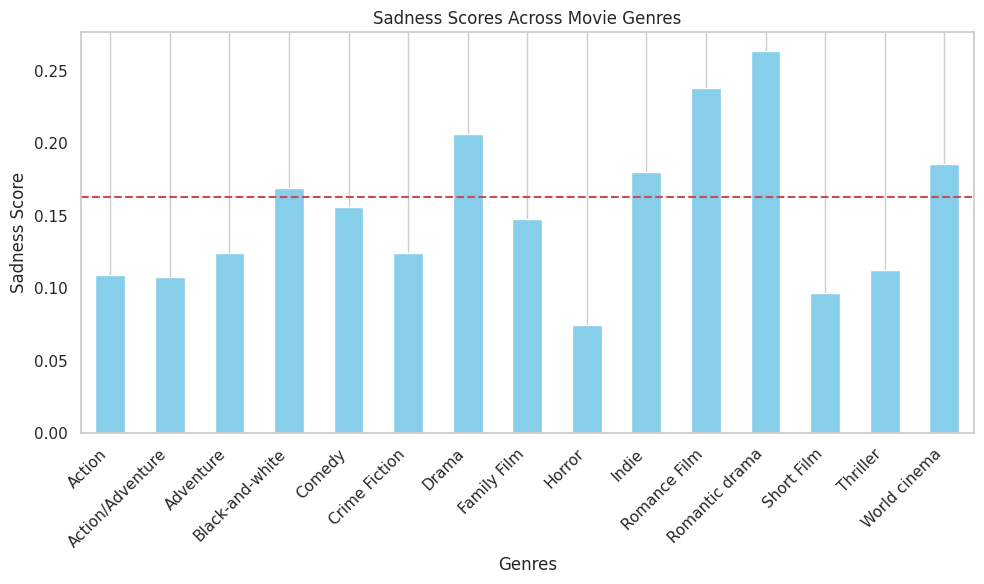

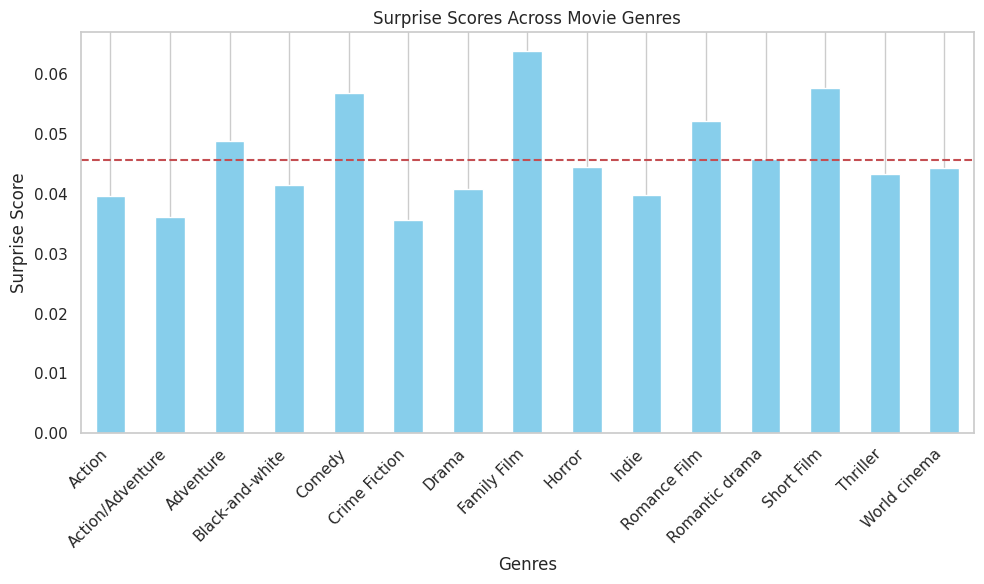

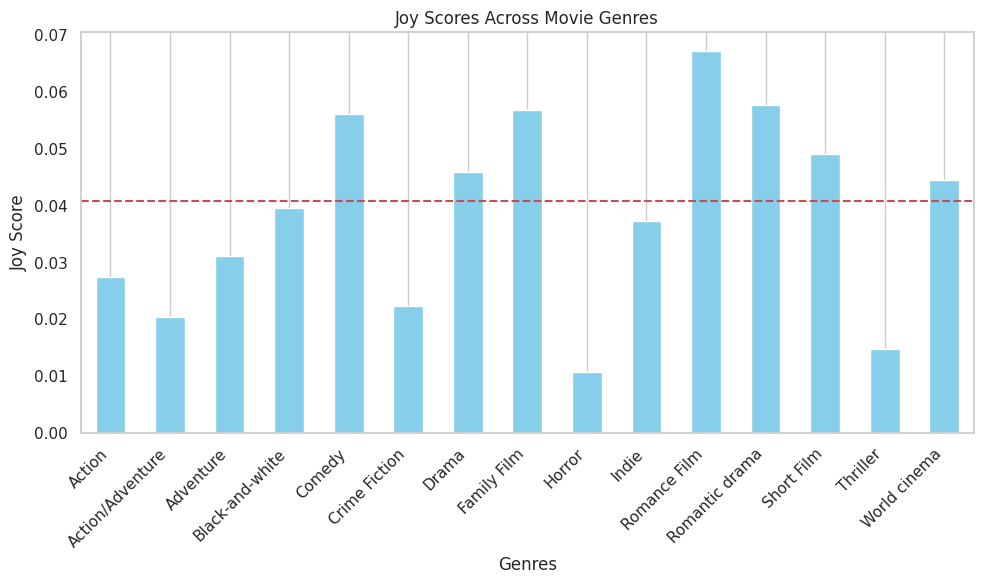

In [22]:
sum_movies = final_df['count'].sum()
weight_avg = final_df[emotions].mul(final_df['count'], axis=0).sum() / sum_movies

for emotion in emotions:
    plt.figure(figsize=(10, 6))
    final_df[emotion].plot(kind = 'bar', title = f"{emotion.capitalize()} Scores Across Movie Genres", color = 'skyblue') 
    plt.axhline(y = weight_avg[emotion], color = 'r', linestyle = '--', label = 'Average Score')
    plt.xlabel('Genres')
    plt.ylabel(f"{emotion.capitalize()} Score")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

We want to understand the predominant tones for each genre, to avoid the bias from the model predictions, we take the emotion that have a statistically significant difference from the average tone by genre using a t-test.

###############################################################
 Statistically significant emotions for Action: anger


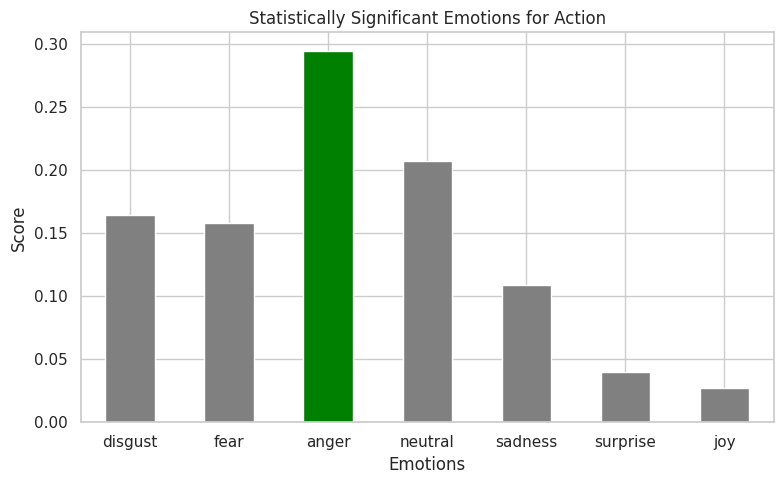

###############################################################
 Statistically significant emotions for Action/Adventure: anger


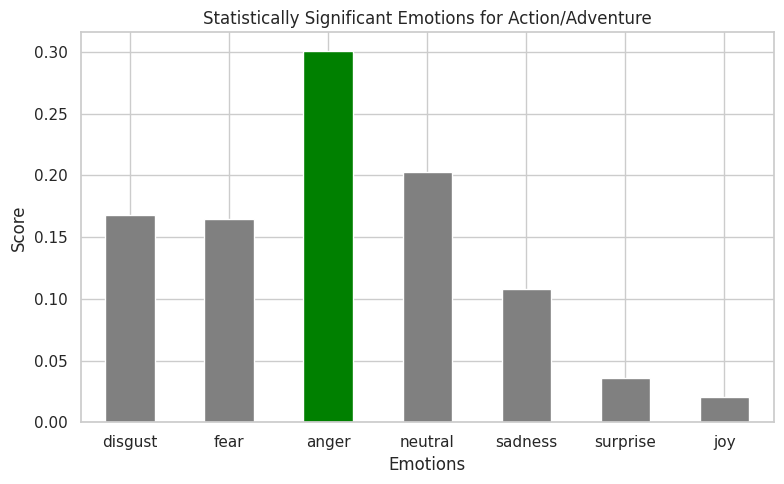

###############################################################
 Statistically significant emotions for Adventure: neutral


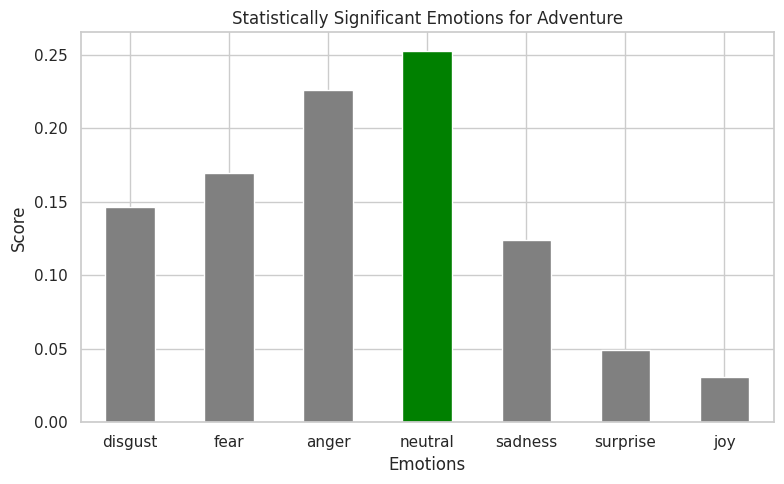

###############################################################
 Statistically significant emotions for Black-and-white: 


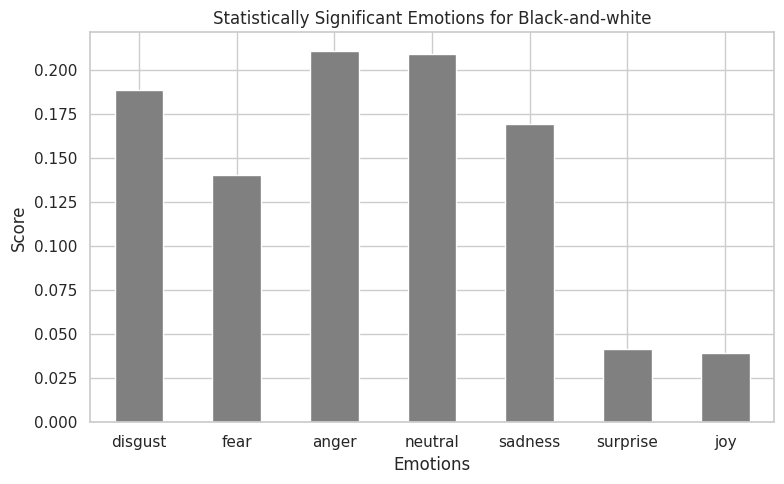

###############################################################
 Statistically significant emotions for Comedy: neutral, surprise, joy


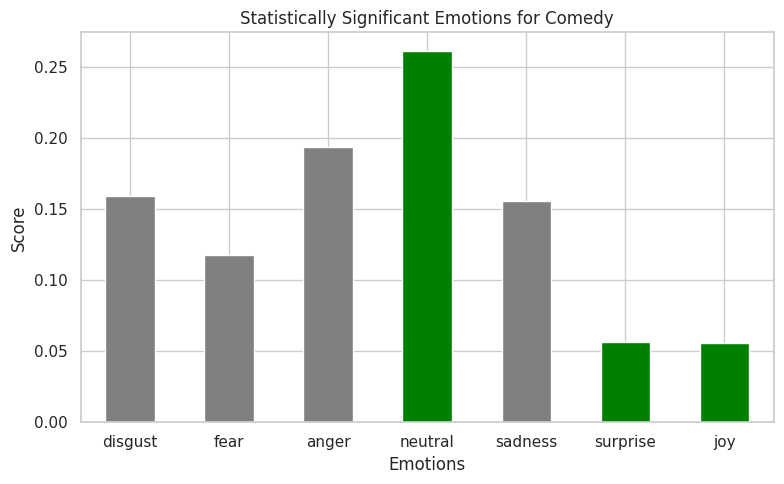

###############################################################
 Statistically significant emotions for Crime Fiction: disgust, anger


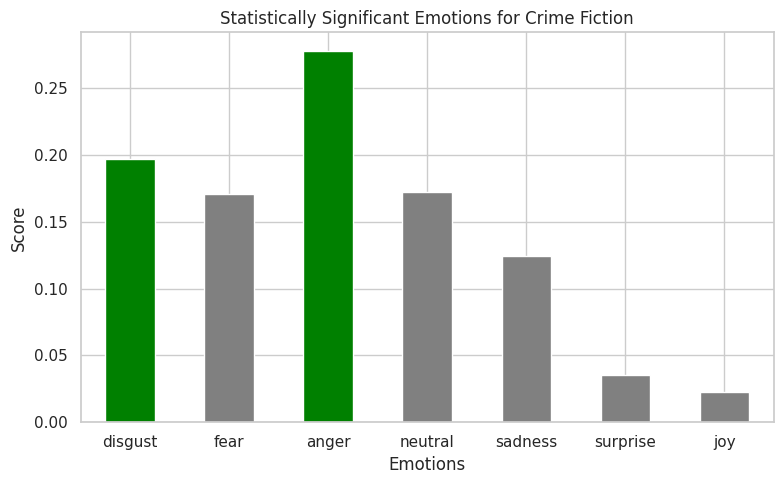

###############################################################
 Statistically significant emotions for Drama: sadness


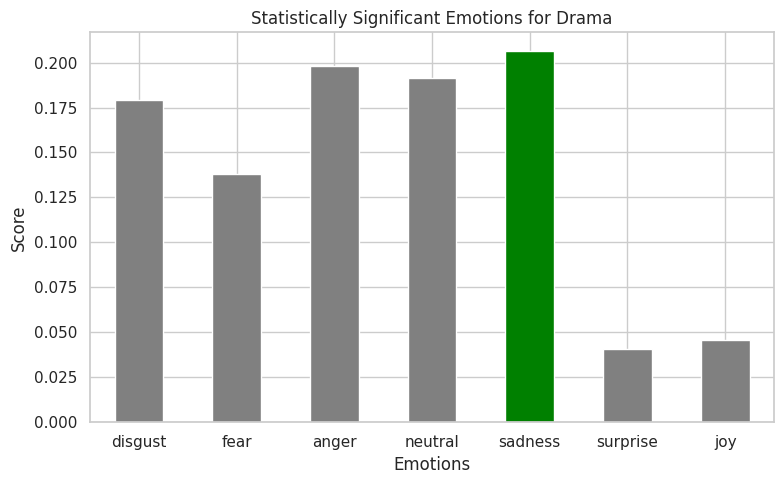

###############################################################
 Statistically significant emotions for Family Film: neutral, surprise, joy


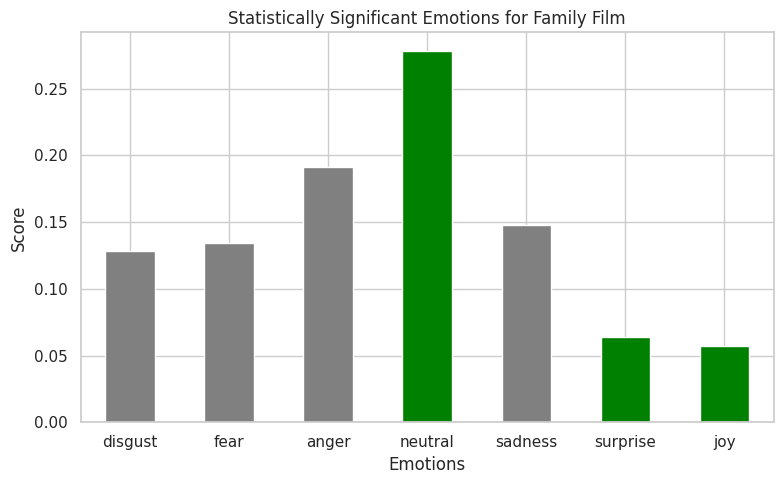

###############################################################
 Statistically significant emotions for Horror: disgust, fear


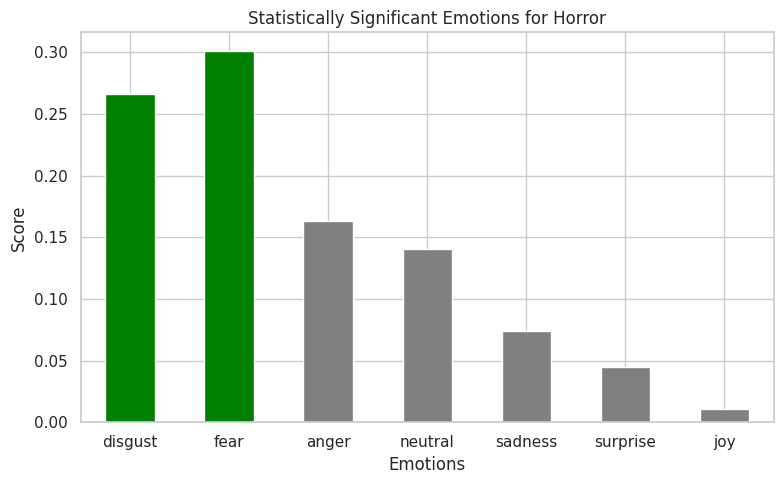

###############################################################
 Statistically significant emotions for Indie: sadness


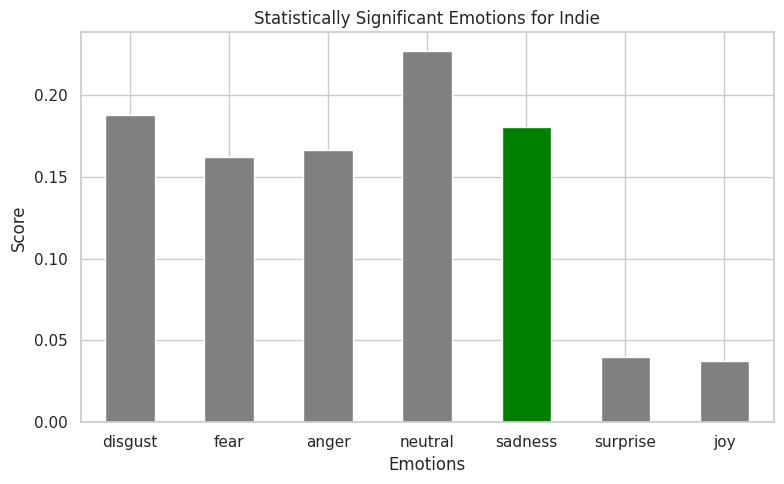

###############################################################
 Statistically significant emotions for Romance Film: sadness, surprise, joy


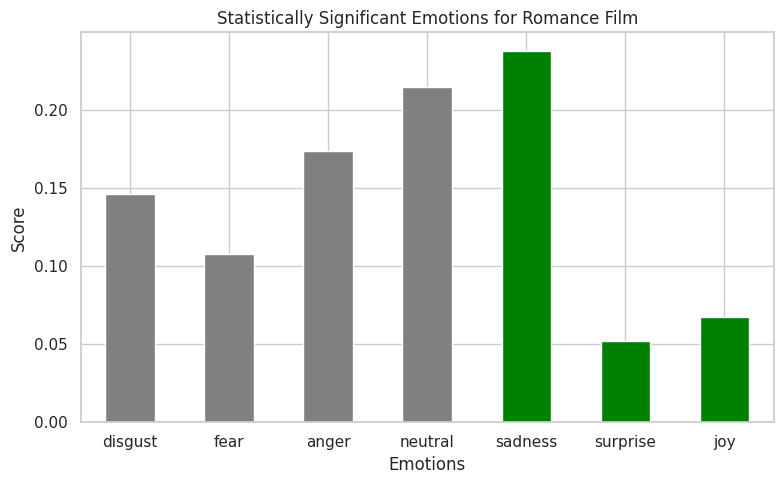

###############################################################
 Statistically significant emotions for Romantic drama: sadness, joy


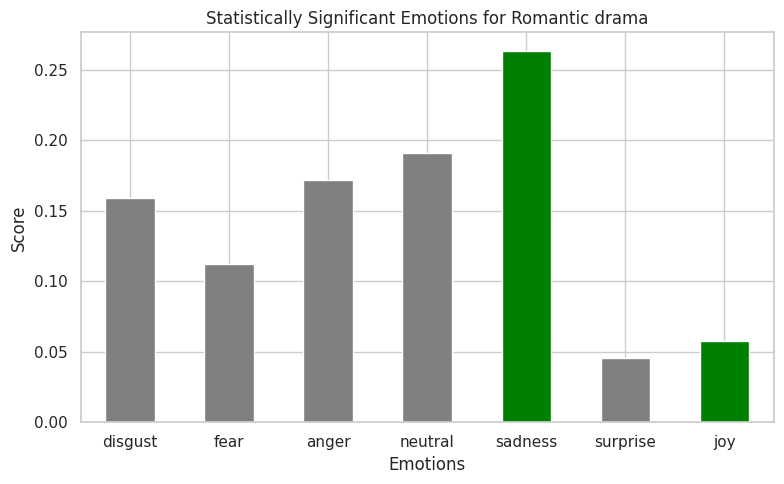

###############################################################
 Statistically significant emotions for Short Film: neutral, surprise, joy


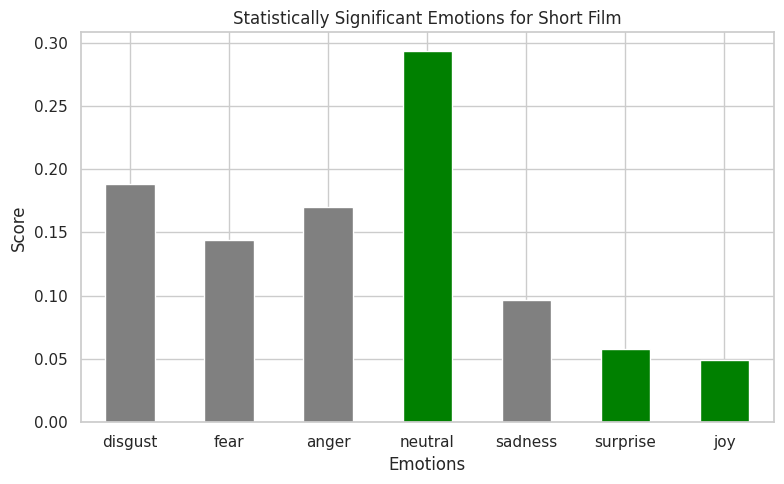

###############################################################
 Statistically significant emotions for Thriller: fear, anger


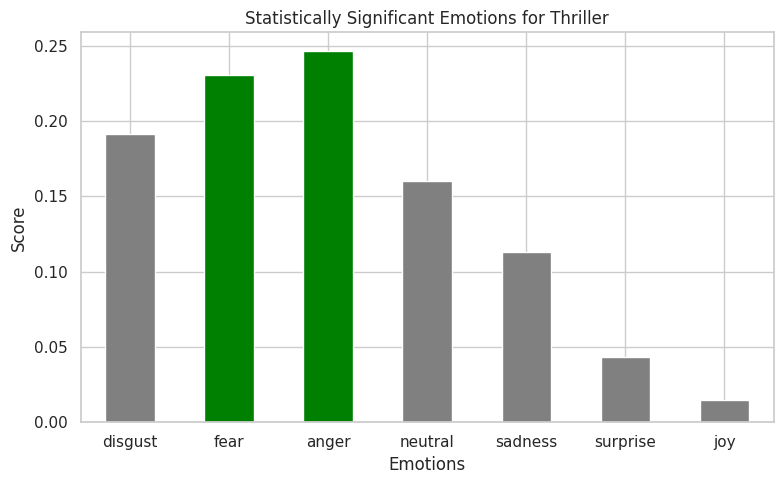

###############################################################
 Statistically significant emotions for World cinema: disgust, sadness


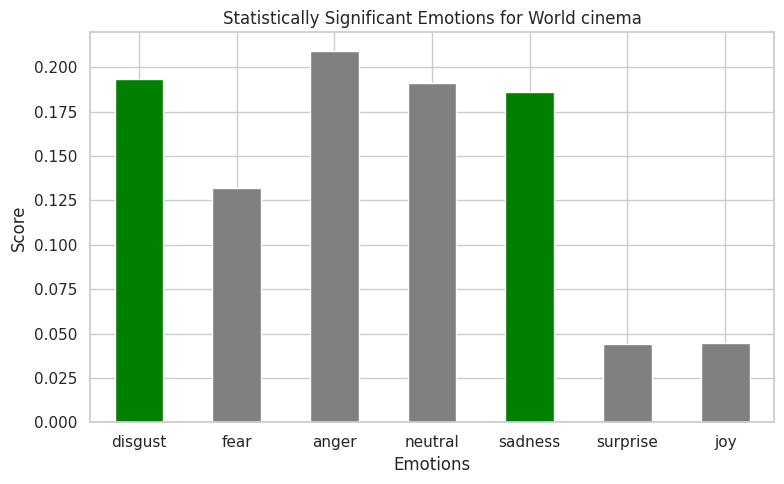

In [23]:
from scipy.stats import ttest_1samp

stat_significant_emotions = {}

for genre in final_df.index:
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = []
    
    for emotion in emotions:
        # Perform a one-sample t-test
        stat, p_value = ttest_1samp(final_df[emotion], genre_emotions[emotion])
        
        if p_value / 2 < 0.05 and genre_emotions[emotion] > weight_avg[emotion]:
            significant_emotions.append(emotion)
    
    stat_significant_emotions[genre] = significant_emotions

for genre in stat_significant_emotions.keys():
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = stat_significant_emotions[genre]
    
    print("###############################################################\n",
          f"Statistically significant emotions for {genre}: {', '.join(significant_emotions)}")
    plt.figure(figsize=(8, 5))
    genre_emotions.plot(kind='bar', color=['green' if emotion in significant_emotions else 'gray' for emotion in emotions])
    plt.title(f"Statistically Significant Emotions for {genre}")
    plt.xlabel("Emotions")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

After analyzing the data, here are the results for each genre:
    Action: The predominant tones is anger, that makes sense, and will we go deeper in trying to understand how the anger emotion changed over time in the time series analysis.

    Action/Adventure: The predominant tones is anger, since the genre is very similar to action, will we only keep the action genre in the time series analysis.

    Adventure: The predominant tones is neutral, al little surprising, but we do not think is interesting to analyse the evolution of a neutral emotion over time. Furthermore, Adveture is still very similar to Action, so we will not keep it in the time series analysis.

    Black-and-White: The is no predominant tone, that make sense, since it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Comedy: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Crime Fiction: The predominant tones are disgust and anger, wi will keep both in the time series analysis.

    Drama: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Family Film: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Horror: The predominant tones are fear and disgust, we will keep both in the time series analysis.

    Indie: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Romance Film: The predominant tones are sadness, joy and surprise, we keep only 2 predominant emotions, sadness and joy, in the time series analysis.

    Romantic Drama: The predominant tones are sadness and joy, since this genre is very similar to Romance Film, we will not keep it in the time series analysis.

    Short Film: The predominant tones are neutral, surprise and joy, we do not think this genre is worth analyze, like 'Black-and-White', it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Thriller: The predominant tones are fear and anger, we will keep both in the time series analysis.

    World cinema: This genre represent film made outside American motion picture industry, particularly those in opposition to the aesthetic and values of the Hollywood mainstream, so we keep it to have an understanding of what is the overall emotion outside the mainstream Hollywood movies. The predominant tones are sadness and disgust, we will keep both in the time series analysis.